## BeCoMe Visualizations -  Results Analysis

This file contains visualizations for demonstrating the BeCoMe algorithm
(Best Compromise Method) on three example datasets:
- Budget Case: COVID-19 budget estimates (22 experts)
- Floods Case: arable land reduction for flood prevention (13 experts)
- Pendlers Case: cross-border worker travel assessment using Likert scale (22 experts)

In [1]:
# Imports
import os
import sys
from pathlib import Path

import ipywidgets as widgets
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from IPython.display import display
from matplotlib.gridspec import GridSpec

# Add project root to Python path for imports to work
project_root = os.path.abspath(os.path.join(os.getcwd(), "../.."))
sys.path.insert(0, project_root)

# Define paths
data_dir = Path(os.getcwd()) / ".." / "data"
output_dir = Path(os.getcwd()) / "output"

from examples.utils import calculate_agreement_level, load_data_from_txt
from src.calculators.become_calculator import BeCoMeCalculator

# Plot settings
plt.style.use("seaborn-v0_8-darkgrid")
sns.set_palette("husl")
plt.rcParams["figure.figsize"] = (12, 6)
plt.rcParams["font.size"] = 10

## 1. Data Loading

Load all three datasets and compute BeCoMe results

In [2]:
# Budget Case
budget_opinions, budget_metadata = load_data_from_txt(str(data_dir / "budget_case.txt"))
budget_calculator = BeCoMeCalculator()
budget_result = budget_calculator.calculate_compromise(budget_opinions)

# Floods Case
floods_opinions, floods_metadata = load_data_from_txt(str(data_dir / "floods_case.txt"))
floods_calculator = BeCoMeCalculator()
floods_result = floods_calculator.calculate_compromise(floods_opinions)

# Pendlers Case
pendlers_opinions, pendlers_metadata = load_data_from_txt(str(data_dir / "pendlers_case.txt"))
pendlers_calculator = BeCoMeCalculator()
pendlers_result = pendlers_calculator.calculate_compromise(pendlers_opinions)

print("Data loaded:")
print(f"  Budget: {len(budget_opinions)} experts, delta_max = {budget_result.max_error:.2f}")
print(f"  Floods: {len(floods_opinions)} experts, delta_max = {floods_result.max_error:.2f}")
print(f"  Pendlers: {len(pendlers_opinions)} experts, delta_max = {pendlers_result.max_error:.2f}")

Data loaded:
  Budget: 22 experts, delta_max = 2.20
  Floods: 13 experts, delta_max = 5.97
  Pendlers: 22 experts, delta_max = 5.68


## 2. Visualization 

### 1: Triangular Membership Functions

Display triangular membership functions for all experts with overlaid curves for arithmetic mean, median, and "best compromise".

Shows how aggregation compresses the distribution of opinions.

In [3]:
def plot_triangular_membership_functions(opinions, result, title, case_name, unit=""):
    """
    Plot triangular membership functions for all experts
    with overlaid aggregated results
    """
    _fig, ax = plt.subplots(figsize=(14, 7))

    # Color scheme
    expert_color = "lightblue"
    expert_alpha = 0.3
    mean_color = "#FF6B6B"
    median_color = "#4ECDC4"
    compromise_color = "#FFD93D"

    # Draw triangles for all experts
    for opinion in opinions:
        lower = opinion.opinion.lower_bound
        peak = opinion.opinion.peak
        upper = opinion.opinion.upper_bound

        # Triangle: (lower, 0) -> (peak, 1) -> (upper, 0)
        x = [lower, peak, upper, lower]
        y = [0, 1, 0, 0]
        ax.fill(x, y, color=expert_color, alpha=expert_alpha, edgecolor="gray", linewidth=0.5)

    # Function to draw aggregated triangle
    def draw_aggregate_triangle(fuzzy_num, color, label, linewidth=3):
        x = [fuzzy_num.lower_bound, fuzzy_num.peak, fuzzy_num.upper_bound, fuzzy_num.lower_bound]
        y = [0, 1, 0, 0]
        ax.plot(x, y, color=color, linewidth=linewidth, label=label, zorder=5)
        ax.fill(x, y, color=color, alpha=0.15, zorder=4)

    # Draw aggregated results with centroid values in legend
    mean_label = (
        f"Arithmetic Mean (Γ)\nCentroid: {result.arithmetic_mean.centroid:.2f} {unit}".strip()
    )
    median_label = f"Median (Ω)\nCentroid: {result.median.centroid:.2f} {unit}".strip()
    compromise_label = (
        f"Best Compromise (ΓΩMean)\nCentroid: {result.best_compromise.centroid:.2f} {unit}".strip()
    )

    draw_aggregate_triangle(result.arithmetic_mean, mean_color, mean_label)
    draw_aggregate_triangle(result.median, median_color, median_label)
    draw_aggregate_triangle(result.best_compromise, compromise_color, compromise_label)

    ax.set_xlabel("Value", fontsize=12, fontweight="bold")
    ax.set_ylabel("Membership Degree mu(x)", fontsize=12, fontweight="bold")
    ax.set_title(
        f"{title}\nTriangular Membership Functions ({len(opinions)} experts)",
        fontsize=14,
        fontweight="bold",
    )
    ax.set_ylim(-0.05, 1.1)
    ax.legend(fontsize=11, loc="upper right")
    ax.grid(True, alpha=0.3)

    # Add patch for individual expert opinions in legend
    expert_patch = mpatches.Patch(
        facecolor=expert_color, alpha=expert_alpha, edgecolor="gray", label="Expert Opinions"
    )
    handles, labels = ax.get_legend_handles_labels()
    handles.insert(0, expert_patch)
    labels.insert(0, "Expert Opinions")
    ax.legend(handles, labels, fontsize=11, loc="upper right")

    plt.tight_layout()
    plt.savefig(
        output_dir / f"{case_name}_membership_functions.png",
        dpi=300,
        bbox_inches="tight",
    )
    plt.show()

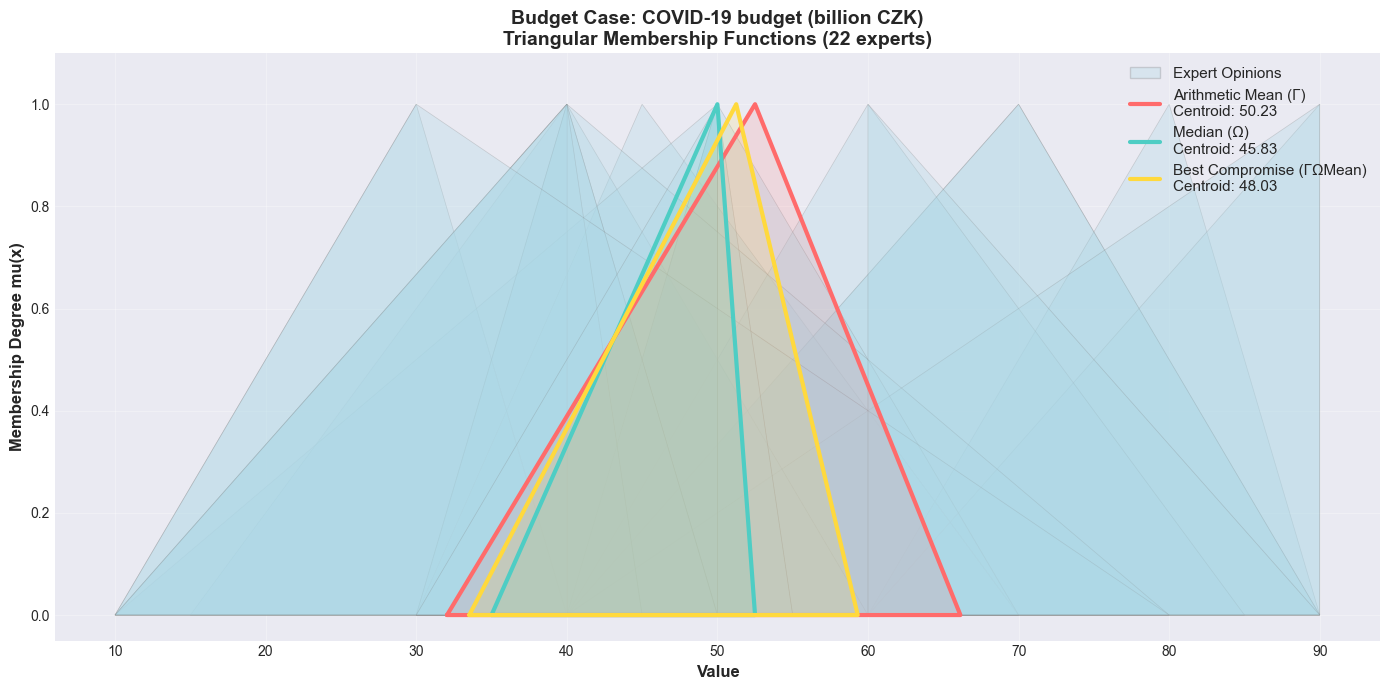

In [4]:
plot_triangular_membership_functions(
    budget_opinions, budget_result, "Budget Case: COVID-19 budget (billion CZK)", "budget"
)

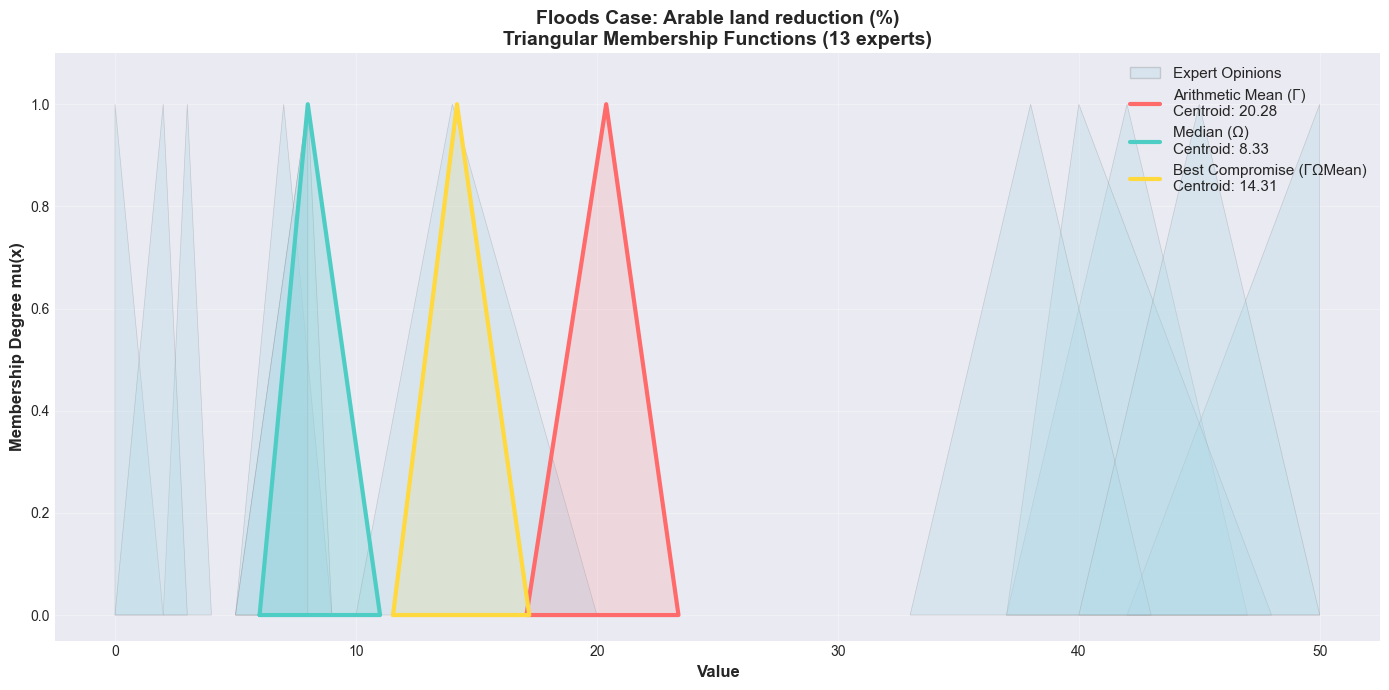

In [5]:
plot_triangular_membership_functions(
    floods_opinions, floods_result, "Floods Case: Arable land reduction (%)", "floods"
)

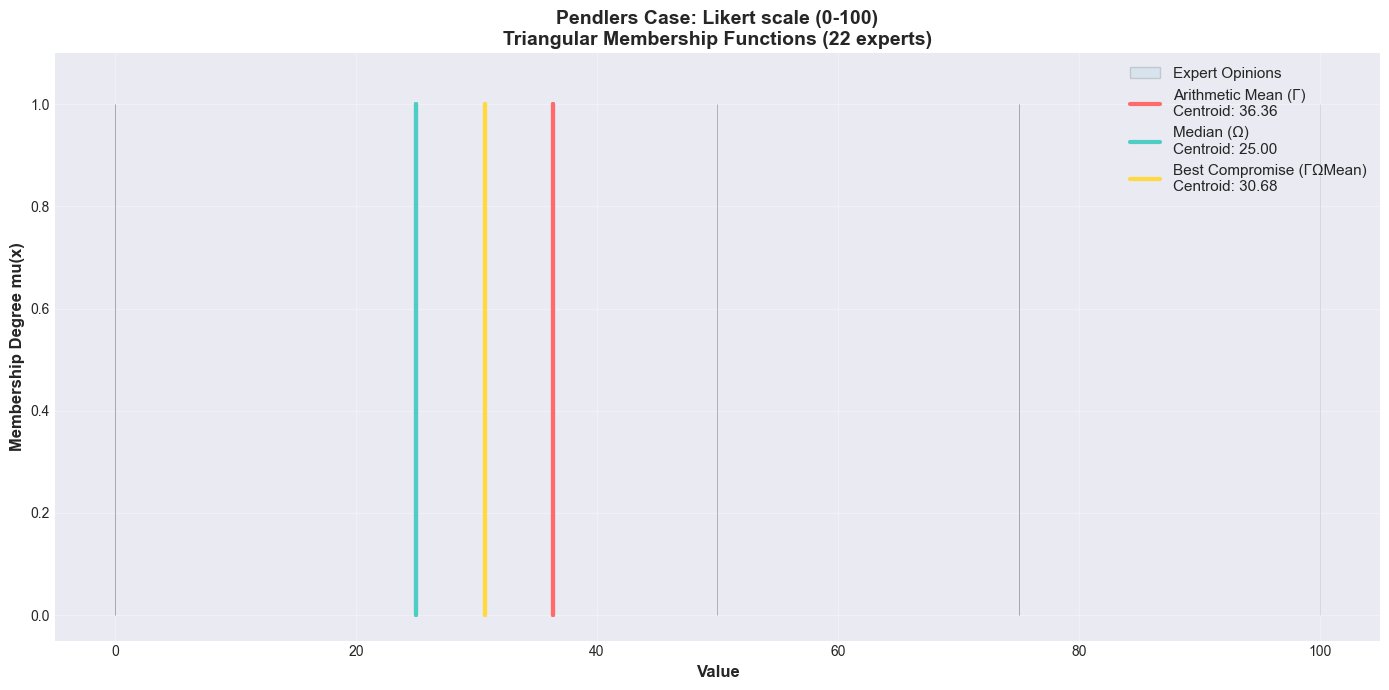

In [6]:
plot_triangular_membership_functions(
    pendlers_opinions, pendlers_result, "Pendlers Case: Likert scale (0-100)", "pendlers"
)

### 2: Centroid Chart

Bar chart with experts sorted by centroids.

Centroids of mean and median values are highlighted.

Delta_max is displayed as half the distance between these points.

In [7]:
def plot_centroid_chart(opinions, result, title, case_name):
    """
    Centroid chart for experts with highlighted aggregated metrics
    """
    # Sort experts by centroid
    sorted_opinions = sorted(opinions, key=lambda op: op.centroid)

    expert_ids = [op.expert_id for op in sorted_opinions]
    centroids = [op.centroid for op in sorted_opinions]

    # Create DataFrame for convenience
    df = pd.DataFrame({"expert_id": expert_ids, "centroid": centroids})

    _fig, ax = plt.subplots(figsize=(14, 7))

    # Bars for experts
    ax.bar(
        range(len(df)),
        df["centroid"],
        color="steelblue",
        alpha=0.7,
        edgecolor="black",
        linewidth=0.5,
    )

    # Horizontal lines for aggregated values
    mean_centroid = result.arithmetic_mean.centroid
    median_centroid = result.median.centroid
    compromise_centroid = result.best_compromise.centroid

    ax.axhline(
        y=mean_centroid,
        color="#FF6B6B",
        linestyle="--",
        linewidth=2.5,
        label=f"Arithmetic Mean (Γ): {mean_centroid:.2f}",
        zorder=5,
    )
    ax.axhline(
        y=median_centroid,
        color="#4ECDC4",
        linestyle="--",
        linewidth=2.5,
        label=f"Median (Ω): {median_centroid:.2f}",
        zorder=5,
    )
    ax.axhline(
        y=compromise_centroid,
        color="#FFD93D",
        linestyle="--",
        linewidth=2.5,
        label=f"Best Compromise (ΓΩMean): {compromise_centroid:.2f}",
        zorder=5,
    )

    # Add delta_max as invisible line for legend
    delta_max = result.max_error
    ax.plot([], [], " ", label=f"δ_max = {delta_max:.2f} (distance between Γ and Ω)")

    ax.set_xlabel("Experts (sorted by centroid)", fontsize=12, fontweight="bold")
    ax.set_ylabel("Centroid Value", fontsize=12, fontweight="bold")
    ax.set_title(
        f"{title}\nExpert Centroids and Aggregated Values",
        fontsize=14,
        fontweight="bold",
    )

    ax.set_xticks(range(len(df)))
    ax.set_xticklabels(df["expert_id"], rotation=45, ha="right")
    ax.legend(fontsize=11, loc="upper left")
    ax.grid(True, alpha=0.3, axis="y")

    plt.tight_layout()
    plt.savefig(
        output_dir / f"{case_name}_centroids.png",
        dpi=300,
        bbox_inches="tight",
    )
    plt.show()

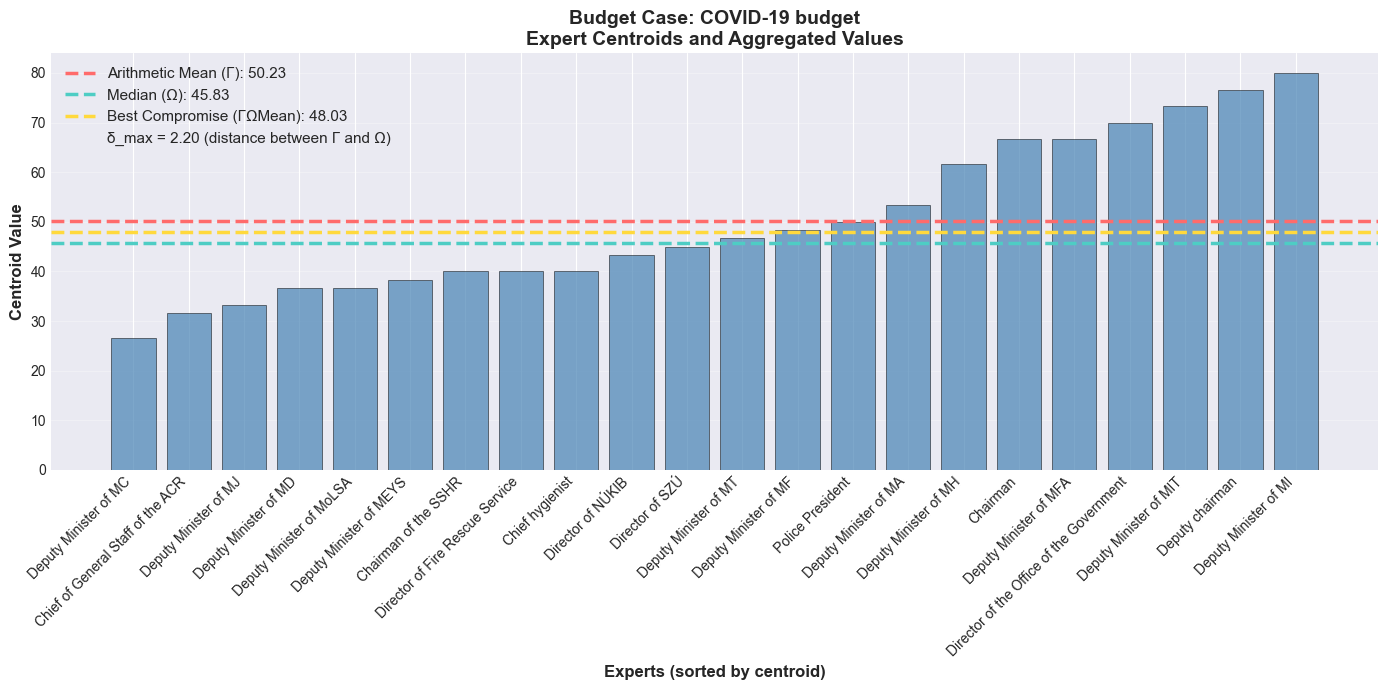

In [8]:
plot_centroid_chart(budget_opinions, budget_result, "Budget Case: COVID-19 budget", "budget")

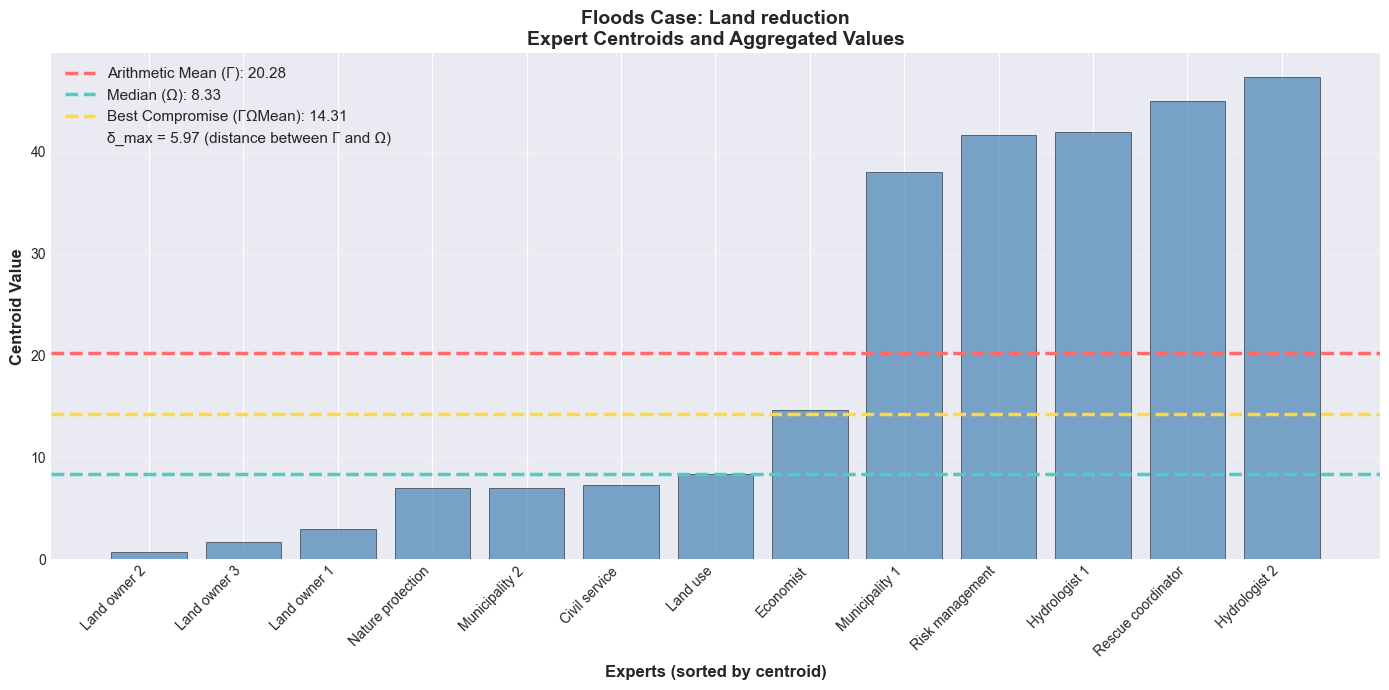

In [9]:
plot_centroid_chart(floods_opinions, floods_result, "Floods Case: Land reduction", "floods")

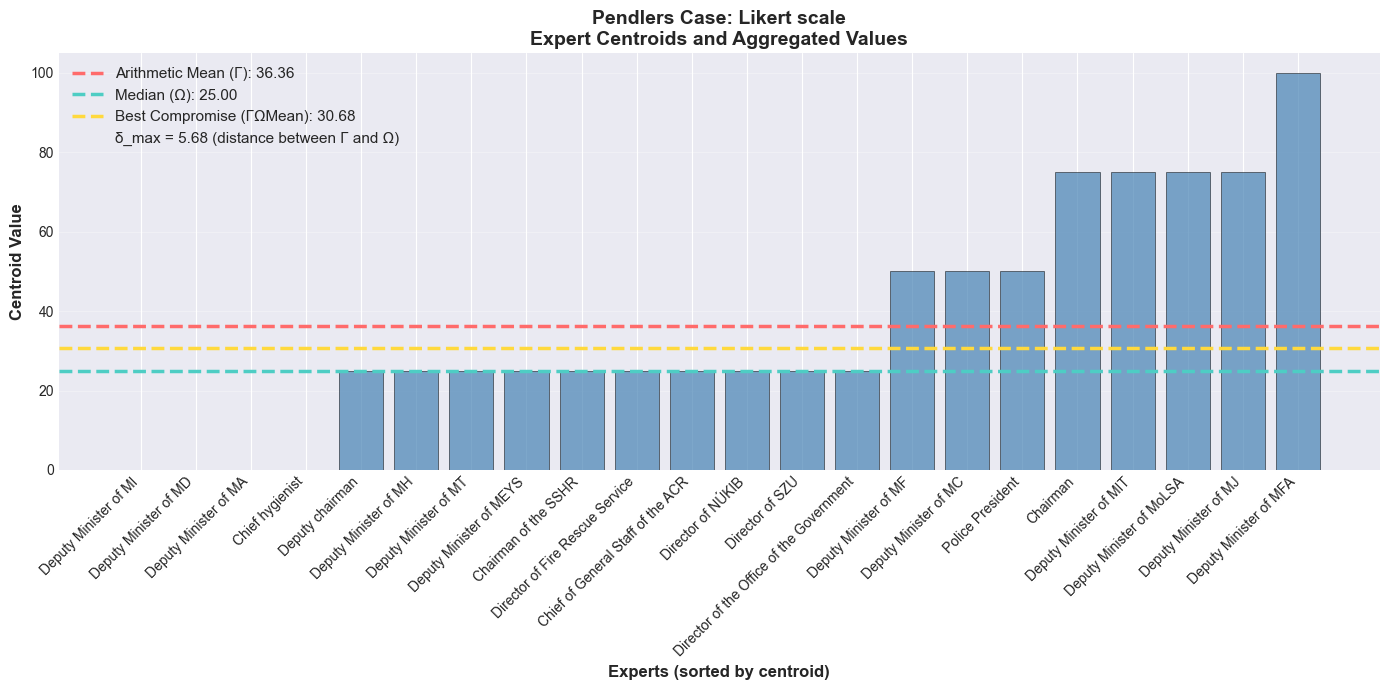

In [10]:
plot_centroid_chart(pendlers_opinions, pendlers_result, "Pendlers Case: Likert scale", "pendlers")

### 3: Interactive Sensitivity Analysis

ipywidgets for including/excluding individual experts. 

Upon each change, aggregates are recalculated and plots are updated, demonstrating method robustness.

In [11]:
def create_sensitivity_analysis_widget(opinions, title, case_name):
    """
    Interactive widget for sensitivity analysis
    """
    # Create checkboxes for each expert
    checkboxes = {}
    for op in opinions:
        checkboxes[op.expert_id] = widgets.Checkbox(
            value=True,
            description=f"{op.expert_id} (c={op.centroid:.1f})",
            style={"description_width": "initial"},
            layout=widgets.Layout(width="350px"),
        )

    # Output widget for plots
    output = widgets.Output()

    def update_plot(change=None):
        """Update plot when expert selection changes"""
        # Get list of selected experts
        selected_opinions = [op for op in opinions if checkboxes[op.expert_id].value]

        if len(selected_opinions) < 2:
            with output:
                output.clear_output(wait=True)
                print("WARNING: Select at least 2 experts for calculation")
            return

        # Recalculate results
        calculator = BeCoMeCalculator()
        result = calculator.calculate_compromise(selected_opinions)

        with output:
            output.clear_output(wait=True)

            _fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

            # Plot 1: Triangular functions
            expert_color = "lightblue"
            for op in selected_opinions:
                x = [
                    op.opinion.lower_bound,
                    op.opinion.peak,
                    op.opinion.upper_bound,
                    op.opinion.lower_bound,
                ]
                y = [0, 1, 0, 0]
                ax1.fill(x, y, color=expert_color, alpha=0.3, edgecolor="gray", linewidth=0.5)

            # Aggregates with full TFN values in legend
            for fuzzy_num, color, base_label in [
                (result.arithmetic_mean, "#FF6B6B", "Mean"),
                (result.median, "#4ECDC4", "Median"),
                (result.best_compromise, "#FFD93D", "Compromise"),
            ]:
                x = [
                    fuzzy_num.lower_bound,
                    fuzzy_num.peak,
                    fuzzy_num.upper_bound,
                    fuzzy_num.lower_bound,
                ]
                y = [0, 1, 0, 0]
                label_with_value = f"{base_label}: [{fuzzy_num.lower_bound:.2f}, {fuzzy_num.peak:.2f}, {fuzzy_num.upper_bound:.2f}]"
                ax1.plot(x, y, color=color, linewidth=2.5, label=label_with_value)

            ax1.set_xlabel("Value", fontweight="bold")
            ax1.set_ylabel("Membership Degree mu(x)", fontweight="bold")
            ax1.set_title(
                f"Membership Functions ({len(selected_opinions)} experts)", fontweight="bold"
            )
            ax1.legend(loc="upper left")
            ax1.grid(True, alpha=0.3)
            ax1.set_ylim(-0.05, 1.1)

            # Plot 2: Centroids
            sorted_ops = sorted(selected_opinions, key=lambda x: x.centroid)
            centroids = [op.centroid for op in sorted_ops]
            expert_ids = [op.expert_id for op in sorted_ops]

            ax2.bar(range(len(centroids)), centroids, color="steelblue", alpha=0.7)

            mean_centroid = result.arithmetic_mean.centroid
            median_centroid = result.median.centroid
            compromise_centroid = result.best_compromise.centroid

            ax2.axhline(
                y=mean_centroid,
                color="#FF6B6B",
                linestyle="--",
                linewidth=2,
                label=f"Mean: {mean_centroid:.2f}",
            )
            ax2.axhline(
                y=median_centroid,
                color="#4ECDC4",
                linestyle="--",
                linewidth=2,
                label=f"Median: {median_centroid:.2f}",
            )
            ax2.axhline(
                y=compromise_centroid,
                color="#FFD93D",
                linestyle="--",
                linewidth=2,
                label=f"Compromise: {compromise_centroid:.2f}",
            )

            ax2.set_xlabel("Experts", fontweight="bold")
            ax2.set_ylabel("Centroid", fontweight="bold")
            ax2.set_title(f"Centroids (delta_max = {result.max_error:.2f})", fontweight="bold")
            ax2.set_xticks(range(len(expert_ids)))
            ax2.set_xticklabels(expert_ids, rotation=45, ha="right")
            ax2.legend()
            ax2.grid(True, alpha=0.3, axis="y")

            plt.tight_layout()
            plt.show()

    # Bind event handlers
    for checkbox in checkboxes.values():
        checkbox.observe(update_plot, names="value")

    # Initial drawing
    update_plot()

    # Layout widgets
    checkbox_cols = []
    items_per_col = 8
    checkbox_list = list(checkboxes.values())

    for i in range(0, len(checkbox_list), items_per_col):
        checkbox_cols.append(widgets.VBox(checkbox_list[i : i + items_per_col]))

    controls = widgets.HBox(checkbox_cols)

    title_widget = widgets.HTML(f"<h3>{title} - Sensitivity Analysis</h3>")
    info_widget = widgets.HTML(
        "<p><i>Select/deselect experts to see the impact on BeCoMe results</i></p>"
    )

    display(widgets.VBox([title_widget, info_widget, controls, output]))

In [12]:
create_sensitivity_analysis_widget(budget_opinions, "Budget Case: COVID-19 budget", "budget")

In [13]:
create_sensitivity_analysis_widget(floods_opinions, "Floods Case: Land reduction", "floods")

In [14]:
create_sensitivity_analysis_widget(pendlers_opinions, "Pendlers Case: Likert scale", "pendlers")

### 4: Scenario Dashboard

Table with key metrics (centroids, delta_max, ranges) and mini-charts for Budget, Floods, Pendlers cases. Facilitates scenario comparison.

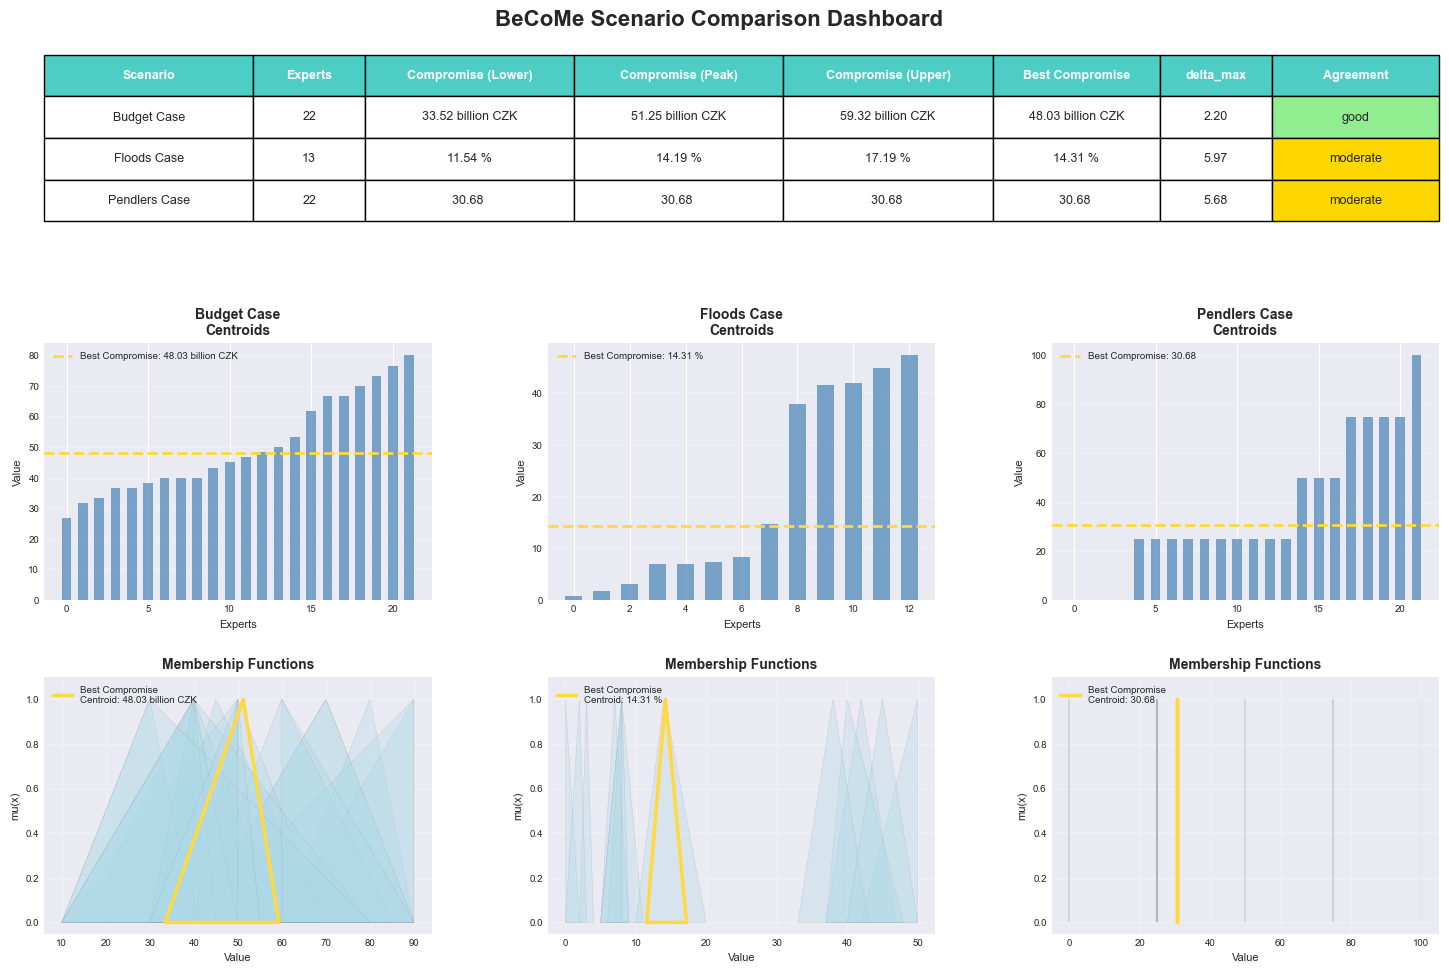

In [15]:
def create_scenario_dashboard():
    """
    Dashboard for comparing all three scenarios
    """
    # Prepare data for metrics table
    scenarios = [
        ("Budget Case", budget_result, len(budget_opinions), "billion CZK"),
        ("Floods Case", floods_result, len(floods_opinions), "%"),
        ("Pendlers Case", pendlers_result, len(pendlers_opinions), ""),
    ]

    metrics_data = []
    for name, result, num_experts, unit in scenarios:
        agreement = calculate_agreement_level(result.max_error, (5.0, 15.0))
        metrics_data.append(
            {
                "Scenario": name,
                "Experts": num_experts,
                "Compromise (Lower)": f"{result.best_compromise.lower_bound:.2f} {unit}",
                "Compromise (Peak)": f"{result.best_compromise.peak:.2f} {unit}",
                "Compromise (Upper)": f"{result.best_compromise.upper_bound:.2f} {unit}",
                "Best Compromise": f"{result.best_compromise.centroid:.2f} {unit}",
                "delta_max": f"{result.max_error:.2f}",
                "Agreement": agreement,
            }
        )

    df_metrics = pd.DataFrame(metrics_data)

    # Create figure with subplots
    fig = plt.figure(figsize=(18, 12))
    gs = GridSpec(3, 3, figure=fig, hspace=0.3, wspace=0.3)

    # Title
    fig.suptitle("BeCoMe Scenario Comparison Dashboard", fontsize=16, fontweight="bold", y=0.88)

    # Metrics table (occupies entire first row)
    ax_table = fig.add_subplot(gs[0, :])
    ax_table.axis("tight")
    ax_table.axis("off")

    table = ax_table.table(
        cellText=df_metrics.values,
        colLabels=df_metrics.columns,
        cellLoc="center",
        loc="center",
        colWidths=[0.15, 0.08, 0.15, 0.15, 0.15, 0.12, 0.08, 0.12],
    )

    table.auto_set_font_size(False)
    table.set_fontsize(9)
    table.scale(1, 2.5)

    # Table styling
    for i in range(len(df_metrics.columns)):
        table[(0, i)].set_facecolor("#4ECDC4")
        table[(0, i)].set_text_props(weight="bold", color="white")

    for i in range(1, len(df_metrics) + 1):
        for j in range(len(df_metrics.columns)):
            if j == len(df_metrics.columns) - 1:  # Agreement column
                agreement_level = df_metrics.iloc[i - 1, j]
                if agreement_level == "good":
                    table[(i, j)].set_facecolor("#90EE90")
                elif agreement_level == "moderate":
                    table[(i, j)].set_facecolor("#FFD700")
                else:
                    table[(i, j)].set_facecolor("#FFB6C1")

    # Mini-charts for each scenario
    scenarios_data = [
        (budget_opinions, budget_result, "Budget Case", 0, "billion CZK"),
        (floods_opinions, floods_result, "Floods Case", 1, "%"),
        (pendlers_opinions, pendlers_result, "Pendlers Case", 2, ""),
    ]

    for opinions, result, name, col_idx, unit in scenarios_data:
        # Centroid chart (upper row)
        ax1 = fig.add_subplot(gs[1, col_idx])
        sorted_ops = sorted(opinions, key=lambda x: x.centroid)
        centroids = [op.centroid for op in sorted_ops]

        centroid_value = result.best_compromise.centroid
        label_text = f"Best Compromise: {centroid_value:.2f} {unit}".strip()

        ax1.bar(range(len(centroids)), centroids, color="steelblue", alpha=0.7, width=0.6)
        ax1.axhline(
            y=centroid_value, color="#FFD93D", linestyle="--", linewidth=2, label=label_text
        )
        ax1.set_title(f"{name}\nCentroids", fontsize=10, fontweight="bold")
        ax1.set_xlabel("Experts", fontsize=8)
        ax1.set_ylabel("Value", fontsize=8)
        ax1.tick_params(labelsize=7)
        ax1.grid(True, alpha=0.3, axis="y")
        ax1.legend(fontsize=7, loc="upper left")

        # Triangular functions chart (lower row)
        ax2 = fig.add_subplot(gs[2, col_idx])

        for op in opinions:
            x = [
                op.opinion.lower_bound,
                op.opinion.peak,
                op.opinion.upper_bound,
                op.opinion.lower_bound,
            ]
            y = [0, 1, 0, 0]
            ax2.fill(x, y, color="lightblue", alpha=0.3, edgecolor="gray", linewidth=0.3)

        # Compromise
        x = [
            result.best_compromise.lower_bound,
            result.best_compromise.peak,
            result.best_compromise.upper_bound,
            result.best_compromise.lower_bound,
        ]
        y = [0, 1, 0, 0]

        # Create informative legend label
        compromise_label = (
            f"Best Compromise\nCentroid: {result.best_compromise.centroid:.2f} {unit}".strip()
        )
        ax2.plot(x, y, color="#FFD93D", linewidth=2.5, label=compromise_label)

        ax2.set_title("Membership Functions", fontsize=10, fontweight="bold")
        ax2.set_xlabel("Value", fontsize=8)
        ax2.set_ylabel("mu(x)", fontsize=8)
        ax2.tick_params(labelsize=7)
        ax2.legend(fontsize=7, loc="upper left")
        ax2.grid(True, alpha=0.3)
        ax2.set_ylim(-0.05, 1.1)

    plt.savefig(
        output_dir / "scenario_dashboard.png",
        dpi=300,
        bbox_inches="tight",
    )
    plt.show()


create_scenario_dashboard()

### 5: Accuracy Gauge Indicator

"Speedometer" or bar chart with quality thresholds (good / moderate / low) for delta_max, allowing instant assessment of expert agreement level.

In [16]:
def plot_accuracy_gauge(result, title, case_name, thresholds=(5.0, 15.0)):
    """
    Accuracy indicator as gauge (speedometer) for delta_max
    """
    delta_max = result.max_error
    agreement = calculate_agreement_level(delta_max, thresholds)

    # Determine color and range
    # Zones: [0, 1/3] = Low, [1/3, 2/3] = Moderate, [2/3, 1] = Good
    if agreement == "good":
        color = "#2ECC71"  # Green
        # Good zone: gauge_value between 2/3 and 1
        # delta_max=0 → gauge_value=1, delta_max=5 → gauge_value=2/3
        gauge_value = 2 / 3 + (1 / 3) * (1 - delta_max / thresholds[0])
        zone = "EXCELLENT AGREEMENT"
    elif agreement == "moderate":
        color = "#F39C12"  # Orange
        # Moderate zone: gauge_value between 1/3 and 2/3
        # delta_max=5 → gauge_value=2/3, delta_max=15 → gauge_value=1/3
        normalized = (delta_max - thresholds[0]) / (thresholds[1] - thresholds[0])
        gauge_value = 2 / 3 - (1 / 3) * normalized
        zone = "MODERATE AGREEMENT"
    else:
        color = "#E74C3C"  # Red
        # Low zone: gauge_value between 0 and 1/3
        # delta_max=15 → gauge_value=1/3, delta_max→∞ → gauge_value=0
        normalized = min((delta_max - thresholds[1]) / thresholds[1], 1.0)
        gauge_value = (1 / 3) * (1 - normalized)
        zone = "LOW AGREEMENT"

    # Create figure with two plots
    fig = plt.figure(figsize=(14, 6))
    gs = GridSpec(1, 2, figure=fig, width_ratios=[1.2, 1])

    # Plot 1: Gauge (semicircle speedometer)
    ax1 = fig.add_subplot(gs[0])

    # Draw semicircle with zones
    # Zones: low (0-pi/3), moderate (pi/3-2pi/3), good (2pi/3-pi)
    zone_ranges = [
        (0, np.pi / 3, "#E74C3C", "Low"),
        (np.pi / 3, 2 * np.pi / 3, "#F39C12", "Moderate"),
        (2 * np.pi / 3, np.pi, "#2ECC71", "Good"),
    ]

    # Draw outer zones
    for start, end, col, _label in zone_ranges:
        theta_zone = np.linspace(start, end, 100)
        x_outer = np.cos(theta_zone)
        y_outer = np.sin(theta_zone)
        x_inner = 0.7 * np.cos(theta_zone)
        y_inner = 0.7 * np.sin(theta_zone)

        # Create polygon for the zone
        vertices = list(zip(x_outer, y_outer, strict=False)) + list(
            zip(x_inner[::-1], y_inner[::-1], strict=False)
        )
        poly = plt.Polygon(vertices, facecolor=col, alpha=0.3, edgecolor=col, linewidth=0)
        ax1.add_patch(poly)

    # Draw white inner circle once
    theta_inner = np.linspace(0, np.pi, 200)
    x_inner_circle = 0.7 * np.cos(theta_inner)
    y_inner_circle = 0.7 * np.sin(theta_inner)
    ax1.fill(
        [*x_inner_circle, x_inner_circle[-1], x_inner_circle[0]],
        [*y_inner_circle, 0, 0],
        color="white",
        zorder=2,
    )

    # Arrow (indicator)
    angle = np.pi * gauge_value
    arrow_length = 0.85
    ax1.arrow(
        0,
        0,
        arrow_length * np.cos(angle),
        arrow_length * np.sin(angle),
        head_width=0.1,
        head_length=0.1,
        fc=color,
        ec=color,
        linewidth=3,
        zorder=5,
    )

    # Central circle
    circle = plt.Circle((0, 0), 0.15, color="black", zorder=10)
    ax1.add_patch(circle)

    # Text with delta_max value
    ax1.text(
        0,
        -0.3,
        f"delta_max = {delta_max:.2f}",
        ha="center",
        va="top",
        fontsize=18,
        fontweight="bold",
        color="black",
    )
    ax1.text(0, -0.45, zone, ha="center", va="top", fontsize=12, fontweight="bold", color="black")

    # Zone labels
    ax1.text(-0.85, 0.5, "High\n(< 5.0)", ha="center", fontsize=9, color="black", fontweight="bold")
    ax1.text(
        0, 1.05, "Moderate\n(5.0-15.0)", ha="center", fontsize=9, color="black", fontweight="bold"
    )
    ax1.text(0.85, 0.5, "Low\n(> 15.0)", ha="center", fontsize=9, color="black", fontweight="bold")

    ax1.set_xlim(-1.2, 1.2)
    ax1.set_ylim(-0.6, 1.3)
    ax1.set_aspect("equal")
    ax1.axis("off")
    ax1.set_title(
        f"{title}\nExpert Agreement Quality Indicator", fontsize=12, fontweight="bold", pad=20
    )

    # Plot 2: Bar chart with thresholds
    ax2 = fig.add_subplot(gs[1])

    ax2.barh(["delta_max"], [delta_max], color=color, height=0.5, edgecolor="black", linewidth=2)

    # Threshold lines
    ax2.axvline(
        x=thresholds[0],
        color="#2ECC71",
        linestyle="--",
        linewidth=2,
        label="High Consensus (δ_max < 5.0)",
    )
    ax2.axvline(
        x=thresholds[1],
        color="#E74C3C",
        linestyle="--",
        linewidth=2,
        label="Low Consensus (δ_max > 15.0)",
    )

    # Background zones
    ax2.axvspan(0, thresholds[0], alpha=0.2, color="#2ECC71")
    ax2.axvspan(thresholds[0], thresholds[1], alpha=0.2, color="#F39C12")
    ax2.axvspan(
        thresholds[1], max(delta_max * 1.2, thresholds[1] * 1.2), alpha=0.2, color="#E74C3C"
    )

    ax2.set_xlabel("delta_max Value", fontsize=11, fontweight="bold")
    ax2.set_title("delta_max Relative to Thresholds", fontsize=12, fontweight="bold")
    ax2.legend(fontsize=9)
    ax2.grid(True, alpha=0.3, axis="x")
    ax2.set_xlim(0, max(delta_max * 1.2, thresholds[1] * 1.2))

    # Value annotation
    ax2.text(
        delta_max + 0.5,
        0,
        f"{delta_max:.2f}",
        va="center",
        fontsize=12,
        fontweight="bold",
        color="black",
    )

    plt.tight_layout()
    plt.savefig(
        output_dir / f"{case_name}_accuracy_gauge.png",
        dpi=300,
        bbox_inches="tight",
    )
    plt.show()

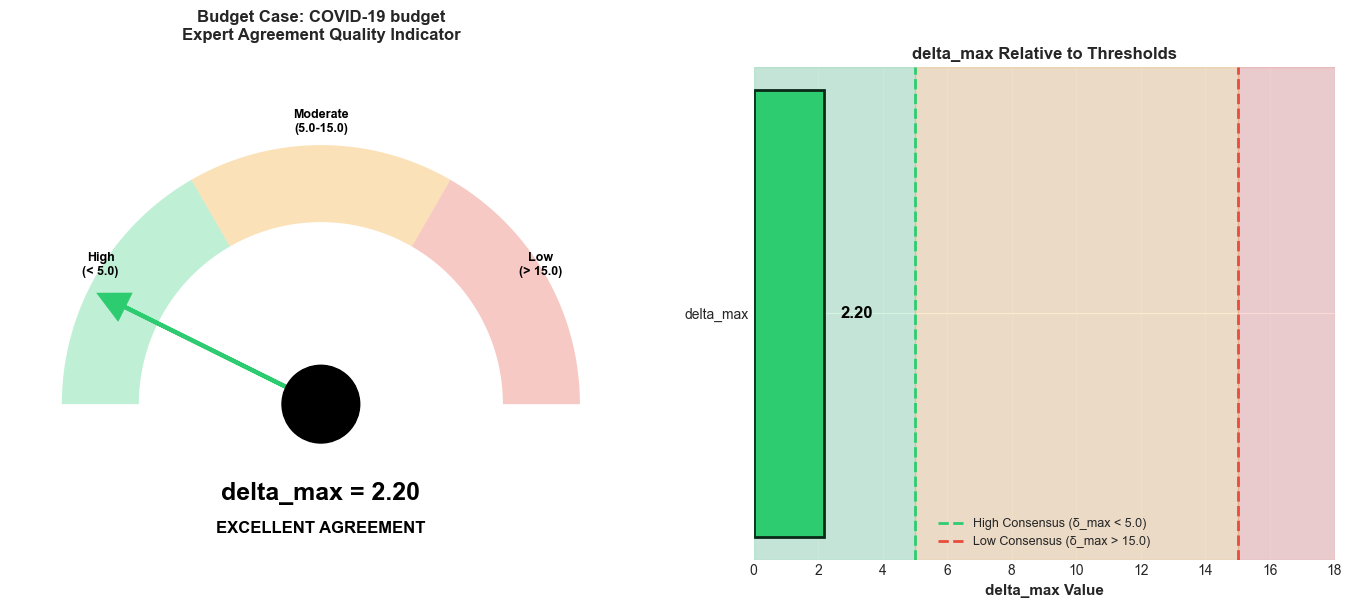

In [17]:
plot_accuracy_gauge(budget_result, "Budget Case: COVID-19 budget", "budget")

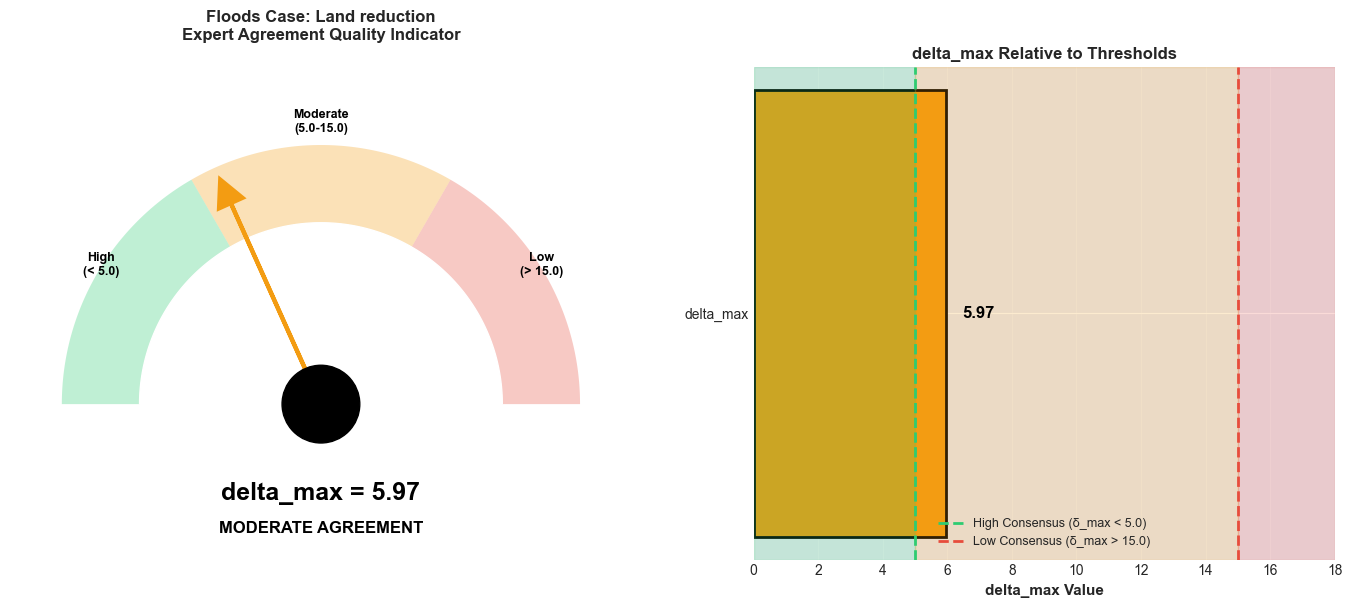

In [18]:
plot_accuracy_gauge(floods_result, "Floods Case: Land reduction", "floods")

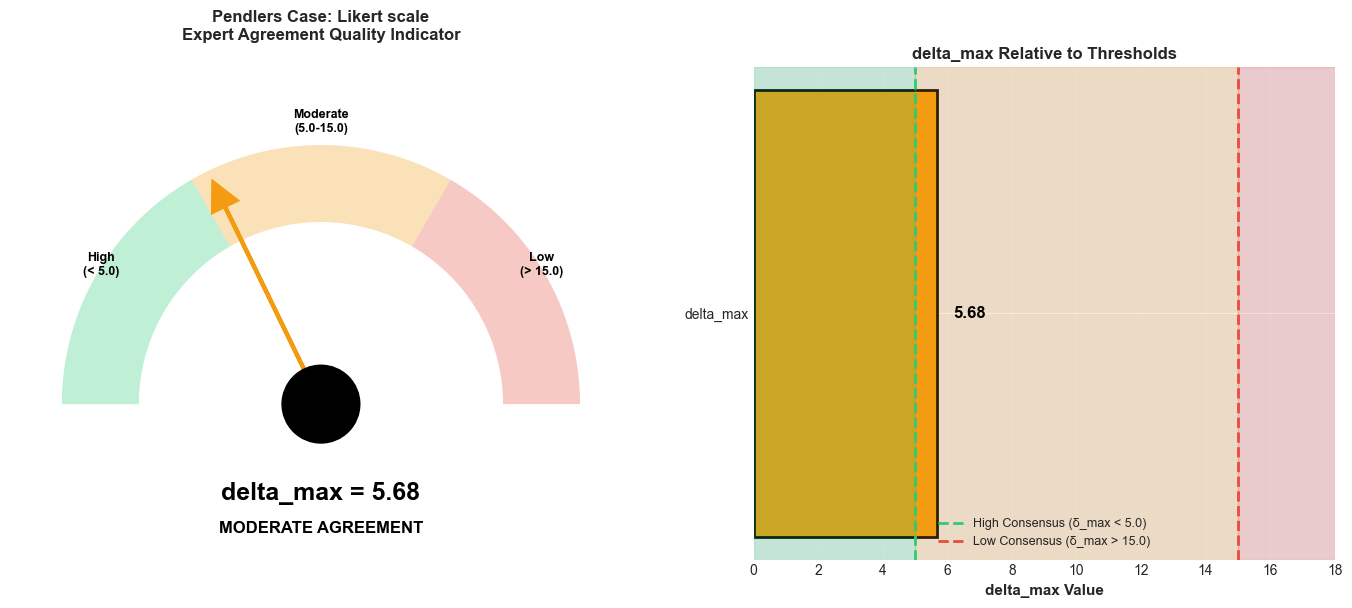

In [19]:
plot_accuracy_gauge(pendlers_result, "Pendlers Case: Likert scale", "pendlers")

## 3. Conclusions and Results Interpretation

### Budget Case
- Experts demonstrate relatively high agreement
- BeCoMe method effectively aggregates diverse opinions
- Compromise solution is within consensus zone

### Floods Case
- Greatest spread of opinions among all scenarios
- delta_max indicates need for additional discussion
- Visualizations help identify expert groups with different positions

### Pendlers Case
- Clear opinion clusters thanks to Likert scale
- Median and mean are close, indicating symmetric distribution
- Compromise well reflects group consensus

### General Observations
- BeCoMe method is robust to outliers (demonstrated in sensitivity analysis)
- Visualizations enable informed decision-making
- Interactive elements increase transparency of aggregation process